In [1]:
from dask.distributed import Client
import dask.dataframe as dd

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50084,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:50096,Total threads: 2
Dashboard: http://127.0.0.1:50097/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:50088,


In [2]:
import numpy as np

import pandas as pd
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import logging
from dask.distributed import Client

import re

In [3]:
ddf = dd.read_csv("medium_reviews.csv", blocksize=50e6, usecols=['reviewerID', 'overall','helpful','reviewTime'])

ddf.head()

,reviewerID,helpful,overall,reviewTime
0,A2T0RJ91B0PQ03,"[0, 0]",1.0,"05 21, 2014"
1,A3TYW0XA8HSGWB,"[0, 0]",5.0,"04 27, 2014"
2,A2CME0TQU2IVVB,"[1, 1]",5.0,"12 19, 2012"
3,A2E5IDLX7R388S,"[0, 0]",5.0,"06 10, 2014"
4,A3CIEMYUGV6ZMR,"[0, 0]",5.0,"04 11, 2012"


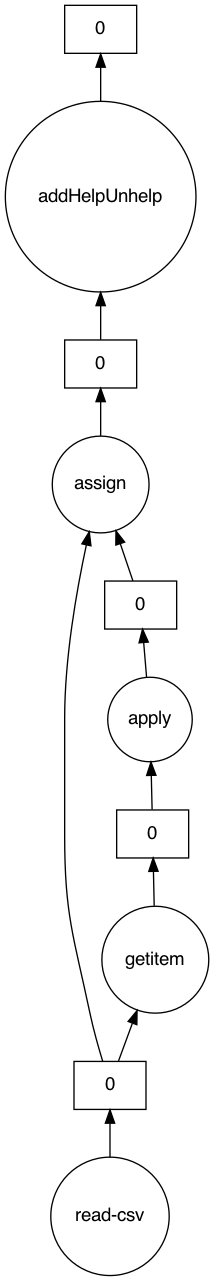

In [4]:


ddf = ddf.assign(reviewYear = lambda x: x.reviewTime.apply(
    lambda x: int(re.search(r"\d{4}", x).group()),
    meta=('reviewTime', 'str')))

def addHelpUnhelp(df):
    helpful_series = df['helpful'].apply(lambda x: np.array(re.findall(r"\d+", x)).astype(int))
    df[['newHelpful', 'totalreviews']] = pd.DataFrame(helpful_series.to_list())
    df['totalreviews'] = df['newHelpful'] + df['totalreviews']
    return df

metadata = {'reviewerID': 'str',
            'helpful': 'str',
            'overall': 'float',
            'reviewTime': 'str',
            'reviewYear': 'float',
            'newHelpful' : 'float',
            'totalreviews': 'float'
            }

ddf = ddf.map_partitions(addHelpUnhelp,
                   #.apply(
    ##lambda x: np.array(re.findall(r"\d+", x)).astype(int),
    meta=metadata
                  )

ddf.visualize()

In [5]:
ddf.compute().head()

,reviewerID,helpful,overall,reviewTime,reviewYear,newHelpful,totalreviews
0,A2T0RJ91B0PQ03,"[0, 0]",1.0,"05 21, 2014",2014,0,0
1,A3TYW0XA8HSGWB,"[0, 0]",5.0,"04 27, 2014",2014,0,0
2,A2CME0TQU2IVVB,"[1, 1]",5.0,"12 19, 2012",2012,1,2
3,A2E5IDLX7R388S,"[0, 0]",5.0,"06 10, 2014",2014,0,0
4,A3CIEMYUGV6ZMR,"[0, 0]",5.0,"04 11, 2012",2012,0,0


In [6]:
#drop extra columnsTODO

#index??
#empiricaly check partitions
groups = ddf.groupby('reviewerID')

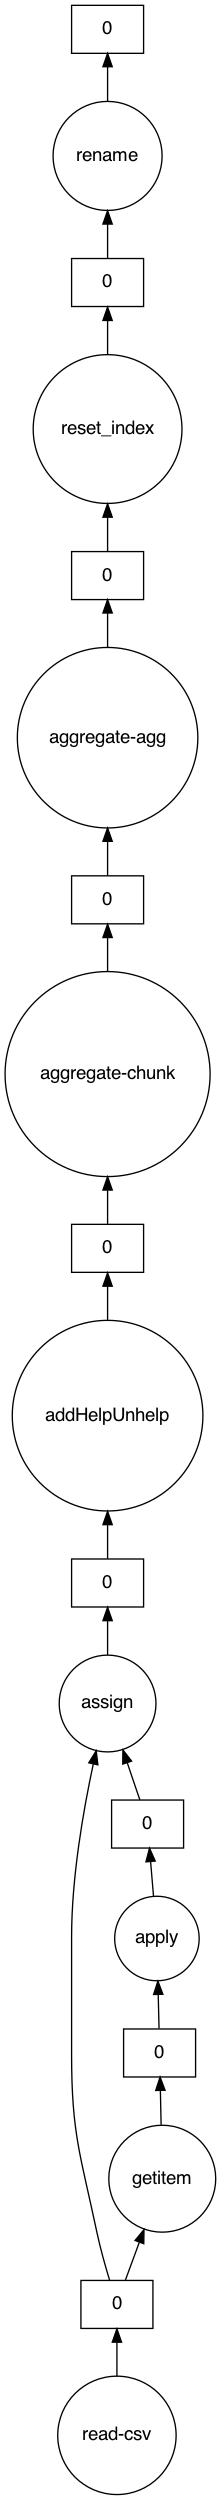

In [7]:
ret = groups.aggregate(
{
    'reviewTime' : 'count',
    'overall' : 'mean',
    'reviewYear' : 'min',
    'newHelpful' : 'sum',
    'totalreviews' : 'sum',
})

#split_out=4)

ret = ret.reset_index().rename(columns={
                    "reviewTime":"number_products_rated", 
                    "overall":"avg_ratings", 
                    "reviewYear":"reviewing_since", 
                    "newHelpful":"helpful_votes", 
                    "totalreviews":"total_votes"})

ret.visualize()


In [8]:
ret.compute().head()

,reviewerID,number_products_rated,avg_ratings,reviewing_since,helpful_votes,total_votes
0,A00010181745VTMHSO9TO,1,5.0,2012,0,0
1,A00187221M0J1WFYMGOVT,1,4.0,2013,0,0
2,A00209543JDFXV1PO75TY,1,4.0,2014,0,0
3,A00254261GWP2LJ0A209G,2,4.5,2013,0,1
4,A002904838P71KCC1O6AU,1,1.0,2014,0,0


In [9]:
# ret['reviewerID']
ret.compute().describe()

,number_products_rated,avg_ratings,reviewing_since,helpful_votes,total_votes
count,163068.000000,163068.000000,163068.000000,163068.000000,163068.000000
mean,1.042504,4.161293,2011.675160,2.048176,4.812029
std,0.398046,1.260303,2.980919,11.048296,23.709710
min,1.000000,1.000000,1997.000000,0.000000,0.000000
25%,1.000000,4.000000,2011.000000,0.000000,0.000000
50%,1.000000,5.000000,2013.000000,0.000000,0.000000
75%,1.000000,5.000000,2013.000000,1.000000,3.000000
max,97.000000,5.000000,2014.000000,1062.000000,2318.000000


In [10]:
# reviews = pd.read_csv("small_reviews.csv")

In [11]:
# number_products_rated = reviews.groupby('reviewerID').count()['asin']
# avg_ratings = reviews.groupby('reviewerID')['overall'].mean()
# reviewing_since = reviews.groupby('reviewerID')['reviewTime'].min()
# helpful_reviews = reviews.groupby('reviewerID')['helpful'].agg(lambda x: sum([int(i.strip('[]').split(', ')[0]) for i in x]))
# total_reviews = reviews.groupby('reviewerID')['helpful'].agg(lambda x: sum([int(i.strip('[]').split(', ')[0]) + int(i.strip('[]').split(', ')[1]) for i in x]))


In [12]:

# users = pd.DataFrame(index = set(reviews['reviewerID']))
# users['number_products_rated'] = number_products_rated
# users['avg_ratings'] = avg_ratings
# users['reviewing_since'] = reviewing_since
# users['helpful_reviews'] = helpful_reviews
# users['total_reviews'] = total_reviews
# users.reset_index(inplace=True)
# users = users.rename(columns = {'index':'reviewerID (PRIMARY KEY)'})
# users
